<a href="https://colab.research.google.com/github/linesn/reddit_analysis/blob/main/Reddit_data_topic_modeling.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Basic Reddit Topic Modeling
Nicholas Lines

This notebook is my work for Module 11 of EN.605.633.81.SP21 Social Media Analytics. The requirements were: 
>Perform topic modeling for social media content of your choice with gensim or an alternative and visualize your results with a tool such as PyLDAvis.

## Overview
We'll show that TFIDF vocabulary preparation is unsatisfactory, and use some simple manual vocabulary reduction techniques to prepare the documents (posts and comments). Then we'll use LDA to topic model the documents and visualize using UMAP.

## Environment setup

In [3]:
%pylab inline
import os
import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.decomposition import NMF, LatentDirichletAllocation

Populating the interactive namespace from numpy and matplotlib


In [4]:
try:
  import lda
  import umap
  import umap.plot
  import plotly.express as px
except:
  !pip install lda
  !pip install umap-learn
  !pip install umap-learn[plot]
  !pip install plotly
  import lda
  import umap
  import umap.plot
  import plotly.express as px

     |████████████████████████████████| 358kB 5.0MB/s 
     |████████████████████████████████| 102kB 5.0MB/s 
     |████████████████████████████████| 81kB 3.6MB/s 
     |████████████████████████████████| 1.2MB 7.5MB/s 
  Created wheel for umap-learn: filename=umap_learn-0.5.1-cp37-none-any.whl size=76569 sha256=13db1b400b175132870a73474484017520577abb5c7757b302ddec66be7ac0ca
  Stored in directory: /root/.cache/pip/wheels/ad/df/d5/a3691296ff779f25cd1cf415a3af954b987fb53111e3392cf4
  Created wheel for pynndescent: filename=pynndescent-0.5.2-cp37-none-any.whl size=51351 sha256=b785301ae078384b9c2c732310b1f3fa711e09b3c91fd28837ede09a37ca06a5
  Stored in directory: /root/.cache/pip/wheels/ba/52/4e/4c28d04d144a28f89e2575fb63628df6e6d49b56c5ddd0c74e
Successfully built umap-learn pynndescent
     |████████████████████████████████| 15.8MB 1.3MB/s 
     |████████████████████████████████| 81kB 8.0MB/s 
     |████████████████████████████████| 112kB 46.5MB/s 
     |████████████████████████████████|

In [5]:
import nltk
from nltk import SnowballStemmer
from nltk.stem.porter import PorterStemmer
from nltk.stem.lancaster import LancasterStemmer
from nltk.stem.wordnet import WordNetLemmatizer

In [6]:
from collections import defaultdict
from scipy.spatial.distance import euclidean

In [7]:
if 'COLAB_GPU' in os.environ: # a hacky way of determining if you are in colab.
  print("Notebook is running in colab")
  from google.colab import drive
  drive.mount("/content/drive")
  DATA_DIR = "./drive/My Drive/Data/"
  
else:
  # Get the system information from the OS
  PLATFORM_SYSTEM = platform.system()

  # Darwin is macOS
  if PLATFORM_SYSTEM == "Darwin":
      EXECUTABLE_PATH = Path("../dependencies/chromedriver")
  elif PLATFORM_SYSTEM == "Windows":
      EXECUTABLE_PATH = Path("../dependencies/chromedriver.exe")
  else:
      logging.critical("Chromedriver not found or Chromedriver is outdated...")
      exit()
  DATA_DIR = "../Data/raw/"

Notebook is running in colab
Mounted at /content/drive


## Get the data and prepare it
First we need to get the data from file.

In [8]:
comment_df = pd.read_csv(DATA_DIR + "raw/Reddit/REDDIT_COMMENTS_2021-02-03T17-02-00-0500.csv")
post_df = pd.read_csv(DATA_DIR + "raw/Reddit/REDDIT_POSTS_2021-02-03T16-56-30-0500.csv")

In [9]:
posts = post_df[["subreddit", "post_id", "post_body"]].dropna().to_numpy()
comments = comment_df[["subreddit", "comment_id", "comment_body"]].dropna().to_numpy()

In [10]:
all_posts = concatenate((posts, comments))

In [11]:
all_text = all_posts[:,2]
subreddits = all_posts[:,0]

In [12]:
len(all_text)

9548

There are several approaches we could take to establish the vocabulary tokens. One that is popular is TFIDF vocabulary extraction, using stopwords and limiting token use by frequency. We'll try that first.

In [13]:
n_features = 10000
tfidf_vectorizer = TfidfVectorizer(max_df=0.95, min_df=0.01,
                                   max_features=n_features,
                                   stop_words='english')

In [14]:
tfidf = tfidf_vectorizer.fit_transform(list(all_text))

In [15]:
tfidf_feature_names = tfidf_vectorizer.get_feature_names()

In [16]:
print(tfidf.shape)
print(tfidf_feature_names)

(9548, 578)
['10', '100', '20', '2020', '2021', '4479er', 'ability', 'able', 'absolutely', 'according', 'accusations', 'act', 'action', 'actions', 'actual', 'actually', 'administration', 'advocating', 'age', 'ago', 'agree', 'allow', 'allowed', 'america', 'american', 'americans', 'answer', 'anti', 'approved', 'approveddomainslist', 'aren', 'argue', 'argument', 'article', 'ask', 'attack', 'automatically', 'away', 'bad', 'ban', 'base', 'based', 'basically', 'bear', 'believe', 'benefit', 'best', 'better', 'biden', 'big', 'biggest', 'bit', 'black', 'bot', 'bring', 'business', 'buy', 'called', 'came', 'campaign', 'canada', 'care', 'case', 'cases', 'cause', 'certain', 'certainly', 'chamber', 'chance', 'change', 'child', 'children', 'china', 'chinese', 'choice', 'choose', 'christian', 'citizens', 'civil', 'claim', 'class', 'clear', 'clearly', 'click', 'climate', 'close', 'com', 'come', 'comes', 'coming', 'comments', 'common', 'companies', 'company', 'completely', 'compose', 'concerns', 'congre

This produced a fairly small number of tokens (cutting off the most common and least common tokens), so I am suspicious that the vocabulary is too small. Let's check it out with a [UMAP](https://umap-learn.readthedocs.io/en/latest/index.html) projection and visualization.

In [17]:
umap_2d = umap.UMAP(n_components=2, init='random', random_state=0)
proj_2d = umap_2d.fit_transform(tfidf)

In [18]:
fig_2d = px.scatter(
    proj_2d, x=0, y=1,
    color=subreddits, labels={'color': 'subreddit'}
)

In [19]:
fig_2d.show()

The plot is not encouraging: it looks like it will be hard to find meaningful clusters. Let's approach this more manually by extracting vocabulary, tokenizing, stemming, and then performing vocabulary reduction using an elbow-cutting method.

In [20]:
def do_stemming(filtered):
	stemmed = []
	for f in filtered:
		#stemmed.append(PorterStemmer().stem(f))
		#stemmed.append(LancasterStemmer().stem(f))
		stemmed.append(SnowballStemmer('english').stem(f))
	return stemmed

In [21]:
all_text_stems = [do_stemming(nltk.casual_tokenize(all_text[i])) for i in range(len(all_text))]

In [22]:
all_stems = defaultdict(int)
for stems in all_text_stems:
  for stem in stems:
    all_stems[stem]+=1

In [23]:
print(len(all_stems))

19625


There are two simple elbow-detection methods we can try. The first uses the second differences to identify the discrete second derivative minimum. The second identifies the point that is furthest from the line connecting the max and min counts. Note that the second is much, much slower.

In [24]:
def elbowcut(list_object):
  figure()
  list_object = sorted(list_object, reverse=True)
  plot(list_object, 'b.')
  d = [list_object[i+1]-list_object[i] for i in range(len(list_object)-1)]
  dd = [abs(d[i+1]-d[i]) for i in range(len(d) - 1)]
  plot(dd,'r.')
  cutoff = argmin(dd)
  plot([list_object[cutoff]],[cutoff],'go')
  return (cutoff, list_object[cutoff])

def elbowcut1(list_object):
  figure()
  list_object = sorted(list_object, reverse=True)
  l = len(list_object)
  plot(list_object[:1000], 'b.')
  x1, y1 = 0, list_object[0]
  xn, yn = len(list_object), list_object[-1] 
  m = (yn-y1)/(xn-x1)
  line = [y1 + m*i for i in range(l)]
  cutoff = argmax([min([euclidean([i, list_object[i]], [j, line[j]]) for j in range(l)]) for i in range(l)])
  plot([cutoff],[list_object[cutoff]], 'go')
  return (cutoff, list_object[cutoff])

by the first elbow cut, we won't accept tokens that occur more than 1084 times


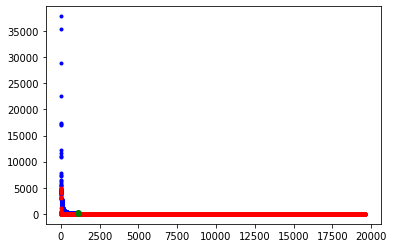

In [25]:
cutoff, upper_bound = elbowcut(list(all_stems.values()))
print("by the first elbow cut, we won't accept tokens that occur more than", upper_bound, "times")
# cutoff, upper_bound = elbowcut1(list(all_stems.values()))
# print("by the second elbow cut, we won't accept tokens that occur more than", upper_bound, "times")

Now we need to trim the vocabulary of the documents.

In [26]:
lower_bound = 5
accept_stems = {stem:all_stems[stem] for stem in all_stems  if (all_stems[stem]<upper_bound and all_stems[stem]>lower_bound)}

In [27]:
print(len(accept_stems))

5346


In [29]:
accept_list = list(accept_stems.keys())

In [30]:
accept_text_stems = [[accept_list.index(j) for j in i if j in accept_stems] for i in all_text_stems]

In [31]:
vectorizer = CountVectorizer(vocabulary=accept_list)

In [32]:
text_matrix = vectorizer.fit_transform(all_text)

Now let's visualize again in UMAP.

In [33]:
umap_2d_voc = umap.UMAP(n_components=2, init='random', random_state=0)
proj_2d_voc = umap_2d_voc.fit_transform(text_matrix)

In [34]:
fig_2d_voc = px.scatter(
    proj_2d_voc, x=0, y=1,
    color=subreddits, labels={'color': 'subreddit'}
)
fig_2d_voc.show()

There's some nice clustering obvious in this plot. One approach to topic modeling is to simply use a clustering technique like k-means to gather these. However, they don't exactly correspond to concept divisions, as you'll see when we label by topic instead of subreddit.

## Train the topic model(s)


We'll use LDA for our topic modeling, though NMF is faster and produces similar results. The LDA package in scikit learn does not use Gibb's sampling last I checked, so I prefer the LDA package from PyPI. 

In [35]:
model5 = lda.LDA(n_topics=5, n_iter=1500, random_state=1)
model10 = lda.LDA(n_topics=10, n_iter=1500, random_state=1)

In [36]:
model5.fit(text_matrix)
model10.fit(text_matrix)

INFO:lda:n_documents: 9548
INFO:lda:vocab_size: 5346
INFO:lda:n_words: 185425
INFO:lda:n_topics: 5
INFO:lda:n_iter: 1500
INFO:lda:<0> log likelihood: -1737457
INFO:lda:<10> log likelihood: -1460153
INFO:lda:<20> log likelihood: -1412331
INFO:lda:<30> log likelihood: -1397150
INFO:lda:<40> log likelihood: -1390782
INFO:lda:<50> log likelihood: -1384747
INFO:lda:<60> log likelihood: -1380806
INFO:lda:<70> log likelihood: -1377236
INFO:lda:<80> log likelihood: -1374510
INFO:lda:<90> log likelihood: -1372654
INFO:lda:<100> log likelihood: -1369595
INFO:lda:<110> log likelihood: -1368568
INFO:lda:<120> log likelihood: -1367113
INFO:lda:<130> log likelihood: -1366049
INFO:lda:<140> log likelihood: -1364797
INFO:lda:<150> log likelihood: -1364085
INFO:lda:<160> log likelihood: -1363100
INFO:lda:<170> log likelihood: -1362527
INFO:lda:<180> log likelihood: -1362522
INFO:lda:<190> log likelihood: -1361622
INFO:lda:<200> log likelihood: -1360985
INFO:lda:<210> log likelihood: -1360460
INFO:lda:<

Here are the topics produced with a selection of 5 topic clusters. 

In [37]:
topic_word = model5.topic_word_  # model.components_ also works
n_top_words = 20
for i, topic_dist in enumerate(topic_word):
  topic_words = np.array(accept_list)[np.argsort(topic_dist)][:-(n_top_words+1):-1]
  print('Topic {}: {}'.format(i, ' '.join(topic_words)))

Topic 0: reddit subreddit wiki don am bot post action contact report civil review here speech index hate media list general attack
Topic 1: china world eu war russia power india new iran over now against trade turkey between uk american into south america
Topic 2: biden vote republican now gop new him news after had much government don first over those covid congress 2020 then
Topic 3: she her me women don him re had men ve man now said fuck shit didn then did bad gender
Topic 4: don re these then those much where doesn same government free into better me still lot person isn system point


These are fairly coherent (though there's some stopwords that could have been removed). The topics can be described as bot and admin posts, world politics, US politics, personal conversation, and a sort of miscelaneous topic.

## Visualize with UMAP

In [38]:
topics = [argmax(doc) for doc in model5.doc_topic_]

In [39]:
fig_2d_voc = px.scatter(
    proj_2d_voc, x=0, y=1,
    color=topics, labels={'color': 'principle topic'}
)
fig_2d_voc.show()

For fun, let's look at a 10-topic model.

In [40]:
topic_word = model10.topic_word_  # model.components_ also works
n_top_words = 20
for i, topic_dist in enumerate(topic_word):
  topic_words = np.array(accept_list)[np.argsort(topic_dist)][:-(n_top_words+1):-1]
  print('Topic {}: {}'.format(i, ' '.join(topic_words)))

topics = [argmax(doc) for doc in model5.doc_topic_]

Topic 0: she her said reddit news after tl had feedback quot 2020 top first far did best dr year 2021 version
Topic 1: government power law system then don legal against those these first court case pardon public after vote may point process
Topic 2: china eu world war russia india power iran new turkey trade over uk now foreign nuclear against taiwan south russian
Topic 3: don re god free doesn me same bad still world those then much these own better lot isn person such
Topic 4: biden republican vote gop him don much new covid now won after win had two did still base congress ll
Topic 5: subreddit wiki reddit don am post action contact bot report civil review here speech index hate help death list media
Topic 6: me him ve re fuck shit down now back got let don then had didn never ll did guy bad
Topic 7: money pay don tax wage market much buy system then job stock less better government short down over minimum where
Topic 8: american america these media social left christian news gover

It is interesting that this one managed to separate out some important subjects like economics (topic 7) and identity politics (topic 9).

In [41]:
fig_2d_voc = px.scatter(
    proj_2d_voc, x=0, y=1,
    color=topics, labels={'color': 'principle topic'}
)
fig_2d_voc.show()

## Conclusion

You can see that the principle topic choice for each document does not correspond very well with UMAP clustering - this is not surprising, since the clusters represent total similarity, whereas the principle topic is just one component of that similarity. At this point an analyst trying to understand the data better would want to run a higher number of topics or a hierarchical model to get more granularity. Another thing to recall is that LDA is better suited to longer documents, and we are using tiny ones. Grouping them by author or thread would help significantly.